In [1]:
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Layer
from tensorflow.keras import Model, Sequential
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os


In [2]:
DATA_FILE = "x.npy"

batch_size = 32
codings_size = 384

## Load Data
Load data and split it into batches. Split into batches because the model(s) has/have a custom training loop and is trained one batch at a time so splitting the data now makes it a little easier later.

In [3]:
x = np.load(DATA_FILE)
img_shape = x.shape[1:]
batches = np.split(x[:len(x)//batch_size * batch_size], len(x)//batch_size)
valid_batches = batches[-1]
batches = batches[:-1]
del x

## Define sampling layer and variational block

In [4]:
# The code for this layer came from the HOML book by Geron
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

keras.utils.get_custom_objects().update({"Sampling": Sampling})

# This was block heavily inspired by the HOML book
def add_variational_block(z):
    z = Flatten()(z)
    codings_mean = Dense(codings_size)(z)
    codings_log_var = Dense(codings_size)(z)
    codings = Sampling()((codings_mean, codings_log_var))
    z = Reshape((1, 1, codings_size))(codings)
    return z, codings_mean, codings_log_var

def latent_loss(codings_mean, codings_log_var):
    latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
    return K.mean(latent_loss) / (img_shape[0]*img_shape[1]*10000)

# input_tensor = Input(shape=(1, 1, codings_size))
# z = input_tensor
# z = Flatten()(z)
# codings_mean = Dense(codings_size)(z)
# codings_log_var = Dense(codings_size)(z)
# codings = Sampling()((codings_mean, codings_log_var))
# output_tensor = Reshape((1, 1, codings_size))(codings)
# variational_block = Model(inputs=[input_tensor], outputs=[output_tensor])

## Define the Models

In [5]:
input_tensor = Input(shape=img_shape)

c1 = Conv2D(6, 5, strides=2, padding="same", activation='selu')
c2 = Conv2D(12, 3, strides=2, padding="same", activation='selu')
c3 = Conv2D(24, 3, strides=2, padding="same", activation='selu')
c4 = Conv2D(48, 3, strides=2, padding="same", activation='selu')
c5 = Conv2D(96, 3, strides=2, padding="same", activation='selu')
c6 = Conv2D(192, 3, strides=2, padding="same", activation='selu')
c7 = Conv2D(codings_size, 3, strides=2, padding="same", activation='selu')

bn1 = BatchNormalization()
bn2 = BatchNormalization()
bn3 = BatchNormalization()
bn4 = BatchNormalization()
bn5 = BatchNormalization()
bn6 = BatchNormalization()

ct1 = Conv2DTranspose(192, 3, strides=2, padding="same", activation='selu')
ct2 = Conv2DTranspose(96, 3, strides=2, padding="same", activation='selu')
ct3 = Conv2DTranspose(48, 3, strides=2, padding="same", activation='selu')
ct4 = Conv2DTranspose(24, 3, strides=2, padding="same", activation='selu')
ct5 = Conv2DTranspose(12, 3, strides=2, padding="same", activation='selu')
ct6 = Conv2DTranspose(6, 3, strides=2, padding="same", activation='selu')
ct7 = Conv2DTranspose(3, 3, strides=2, padding="same", activation='sigmoid')

In [6]:
training_models = [
    Sequential([input_tensor, c1, bn1, ct7]),
    Sequential([input_tensor, c1, bn1, c2, bn2, ct6]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, ct5]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, ct4]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, ct3]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, ct2]),
    # Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, c7, variational_block, ct1]),
]

z = input_tensor
for layer in [c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, c7]:
    z = layer(z)
z, codings_mean_intermediate, codings_log_var_intermediate = add_variational_block(z)
output_tensor = ct1(z)

last_training_model = Model(inputs=[input_tensor], outputs=[output_tensor])
last_training_model.add_loss(latent_loss(codings_mean_intermediate, codings_log_var_intermediate))
for layer in last_training_model.layers[:12]:
    layer.trainable=False
last_training_model.compile(optimizer="RMSprop", loss="MSE")

training_models.append(last_training_model)

targets = []

z = input_tensor
targets.append(z)
z = c1(z)
targets.append(z)
z = bn1(z)
z = c2(z)
targets.append(z)
z = bn2(z)
z = c3(z)
targets.append(z)
z = bn3(z)
z = c4(z)
targets.append(z)
z = bn4(z)
z = c5(z)
targets.append(z)
z = bn5(z)
z = c6(z)
targets.append(z)
z = bn6(z)
z = c7(z)

z, codings_mean, codings_log_var = add_variational_block(z)

for layer in [ct1, bn6, ct2, bn5, ct3, bn4, ct4, bn3, ct5, bn2, ct6, bn1, ct7]:
    z = layer(z)

output_tensor = z

for model in training_models[:-1]:
    for layer in model.layers[:-4]:
        layer.trainable = False
    model.compile(optimizer="RMSprop", loss="MSE")

# model = training_models[-1]
# for layer in model.layers[:-3]:
#         layer.trainable = False

target_model = Model(inputs=[input_tensor], outputs=targets)
inference_model = Model(inputs=[input_tensor], outputs=[output_tensor])

training_models[0].summary()
training_models[-1].summary()
inference_model.summary()

# stacked_model = keras.models.clone_model(inference_model)
inference_model.add_loss(latent_loss(codings_mean, codings_log_var))
inference_model.compile(optimizer="adam", loss="MSE", metrics=["mean_absolute_error"])
# stacked_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 128, 128, 3)       165       
Total params: 645
Trainable params: 165
Non-trainable params: 480
_________________________________________________________________
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
___________________________________________________________________

In [8]:
def train_step(batch):
    # targets = target_model.predict(batch)
    inference_model.train_on_batch(batch, batch)
    # for i, model in enumerate(training_models):
    #     model.train_on_batch(batch, targets[i])
    
    # stacked_model.train_on_batch(batch, batch)

# inference_model = keras.models.load_model("inference.h5")
# stacked_model = keras.models.load_model("stacked.h5")

epochs = 10
for i in range(epochs):
    print("\nEpoch %d/%d" % (i, epochs))
    for batch in tqdm(batches):
        train_step(batch)
# inference_model.fit(x, x)

  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 0/10
  1%|          | 3/413 [00:00<00:19, 20.68it/s]
Epoch 1/10
  1%|          | 3/413 [00:00<00:20, 20.47it/s]
Epoch 2/10
  1%|          | 3/413 [00:00<00:20, 20.50it/s]
Epoch 3/10
  1%|          | 3/413 [00:00<00:20, 20.36it/s]
Epoch 4/10
  1%|          | 3/413 [00:00<00:19, 20.76it/s]
Epoch 5/10
  1%|          | 3/413 [00:00<00:19, 21.36it/s]
Epoch 6/10
  1%|          | 3/413 [00:00<00:20, 20.36it/s]
Epoch 7/10
  1%|          | 3/413 [00:00<00:20, 20.43it/s]
Epoch 8/10
  1%|          | 3/413 [00:00<00:19, 20.73it/s]
Epoch 9/10
100%|██████████| 413/413 [00:20<00:00, 20.19it/s]


In [17]:
# inference_model.save("var_inference.h5")
# stacked_model.save("var_stacked.h5")

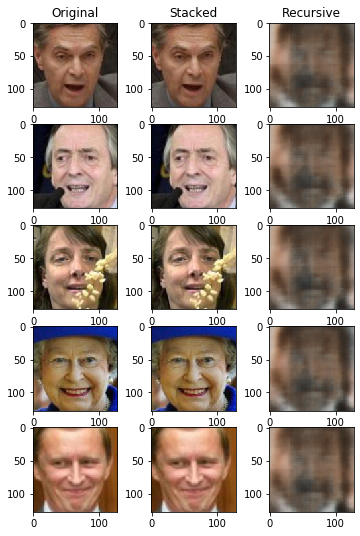

In [9]:
batches = np.array(batches)
B, N, _, _, _ = batches.shape
num_images = 5
batches_ind = np.random.randint(0, B, num_images)
imgs = np.random.randint(0, N, num_images)
display_images = valid_batches[imgs, :, :, :]

reconstructions = inference_model.predict(display_images)
# basic_reconstructions = stacked_model.predict(display_images)
basic_reconstructions = display_images

fig, axs = plt.subplots(5, 3)

titles = ["Original", "Stacked", "Recursive"]

for r, row in enumerate(axs):
    imgs = [display_images[r], basic_reconstructions[r], reconstructions[r]]
    for c, ax in enumerate(row):
        img = imgs[c].astype(float)
        ax.imshow(img)
        if r == 0:
            ax.set_title(titles[c])

fig.set_size_inches(6, 9)
fig.savefig("faces.png")
fig.show()